# Market Prices

Data obtained from [REN Datahub](https://mercado.ren.pt/PT/Electr/InfoMercado/InfOp/MercOmel/Paginas/Precos.aspx).

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import xgboost as xgb

warnings.filterwarnings("ignore")

# import sklearn performance metrics
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)


In [2]:
df = pd.read_excel("../data/PrecoMerc.xlsx")
df.head()

KeyboardInterrupt: 

In [ ]:
df.columns = ["date", "hour", "session", "price_pt", "price_es"]
df = df[df['session'] == 0][["date", "hour", "price_pt"]]
df.head()

,date,hour,price_pt
0,2008-07-01,1,70.31
1,2008-07-01,2,64.54
2,2008-07-01,3,64.08
3,2008-07-01,4,63.50
4,2008-07-01,5,63.28


In [ ]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["hour"] = pd.to_timedelta(df["hour"], unit="h")
df["date"] = df["date"] + df["hour"]
df.head()

,date,hour,price_pt
0,2008-07-01 01:00:00,0 days 01:00:00,70.31
1,2008-07-01 02:00:00,0 days 02:00:00,64.54
2,2008-07-01 03:00:00,0 days 03:00:00,64.08
3,2008-07-01 04:00:00,0 days 04:00:00,63.50
4,2008-07-01 05:00:00,0 days 05:00:00,63.28


In [ ]:
df = df[["date", "price_pt"]]
df.rename(columns={"price_pt": "price"}, inplace=True)
df.head()

,date,price
0,2008-07-01 01:00:00,70.31
1,2008-07-01 02:00:00,64.54
2,2008-07-01 03:00:00,64.08
3,2008-07-01 04:00:00,63.50
4,2008-07-01 05:00:00,63.28


In [ ]:
# df.to_csv("../data/MarketPricePT.csv", index=False)

# Simulation

In this section, we will simulate the management system of the REC.

In [3]:
try:
    df
except NameError:
    df = pd.read_csv("../data/MarketPricePT.csv", parse_dates=["date"])

In [4]:
df.head()

,date,price
0,2008-07-01 01:00:00,70.31
1,2008-07-01 02:00:00,64.54
2,2008-07-01 03:00:00,64.08
3,2008-07-01 04:00:00,63.50
4,2008-07-01 05:00:00,63.28


In [5]:
energy_df = pd.read_csv("../data/BANES_v4_featureimportance.csv")
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
0,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,0.000,0.000,0.005,0.000,0.000,0.000
1,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,0.000,0.005,0.005,0.005,0.000,0.000
2,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,0.000,0.005,0.006,0.005,0.005,0.000
3,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,0.000,0.006,0.005,0.006,0.005,0.005
4,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,0.006,0.005,0.005,0.005,0.006,0.005


In [6]:
# pick 10 locations at random
locs = energy_df.sample(10, random_state=1).index.tolist()
locations = energy_df.iloc[locs]["location"]
assert len(locations) == 10 and len(np.unique(locations)) == 10
energy_df = energy_df[energy_df["location"].isin(locations)]
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338


In [7]:
model: xgb.XGBRegressor = pickle.load(open("../models/model_v1.pkl", "rb"))

In [8]:
X = energy_df.drop(["location", "time", "energy"], axis=1)
y = model.predict(X)

In [9]:
energy_df["energy_pred"] = y
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334,0.340560
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335,0.342466
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334,0.342466
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333,0.342042
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338,0.340794


In [10]:
# group by date and sum the energy_pred
energy_df = energy_df.groupby("time").sum()
energy_df.head()

,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
time,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.4145,15.6905,19.0515,13.7410,13.665,10.4265,12.630360
2017-01-08 00:30:00+00:00,15.5335,12.1005,15.7690,16.3645,14.3410,13.741,13.6650,13.138655
2017-01-08 01:00:00+00:00,15.8120,15.5335,15.9685,15.1790,13.9740,14.341,13.7410,15.286879
2017-01-08 01:30:00+00:00,15.2760,15.8120,15.6965,14.6085,13.7320,13.974,14.3410,15.399491
2017-01-08 02:00:00+00:00,15.6635,15.2760,15.5890,14.2770,13.7605,13.732,13.9740,15.031993


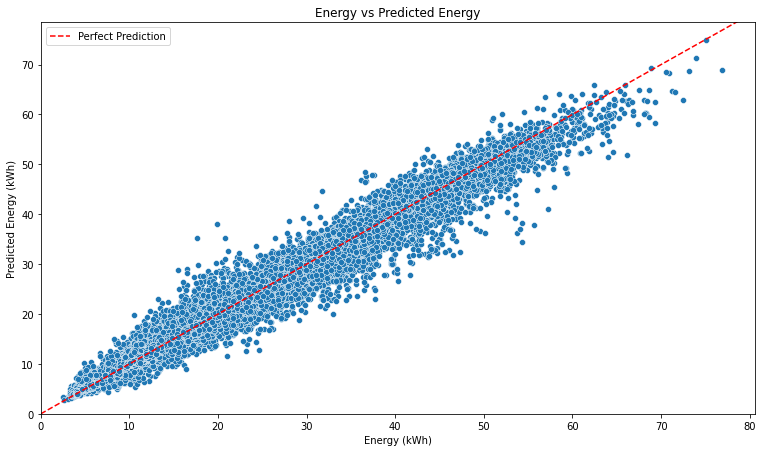

In [11]:
plt.figure(figsize=(12.8, 7.2))

sns.scatterplot(data=energy_df, x="energy", y="energy_pred")
plt.xlabel("Energy (kWh)")
plt.ylabel("Predicted Energy (kWh)")
plt.title("Energy vs Predicted Energy")
plt.xlim(0, None)
plt.ylim(0, None)
plt.plot([0, 100], [0, 100], "r--")
plt.legend(["Perfect Prediction"])
plt.show()

<Figure size 921.6x518.4 with 0 Axes>

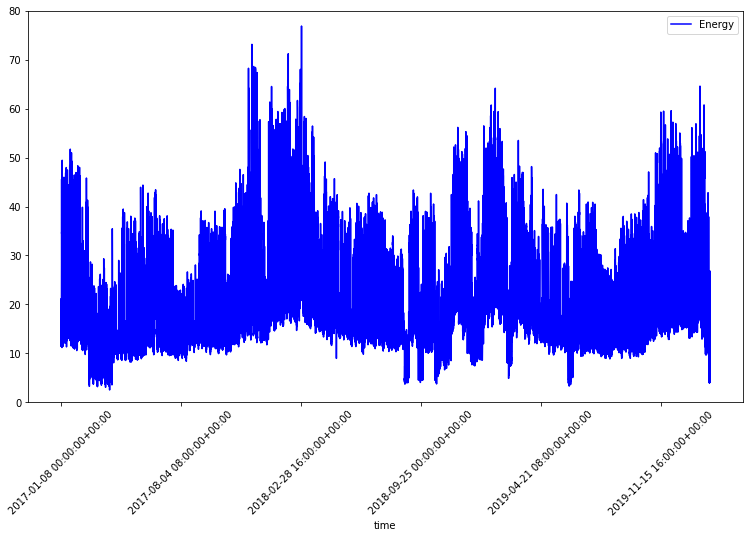

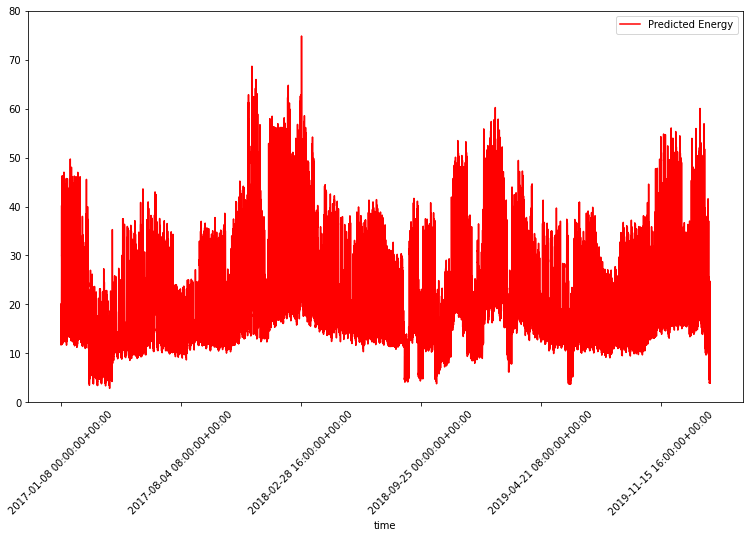

In [12]:
plt.figure(figsize=(12.8, 7.2))

energy_df.plot(y="energy", figsize=(12.8, 7.2), c="b", label="Energy")
plt.ylim(0, 80)
plt.xticks(rotation=45)
energy_df.plot(y="energy_pred", figsize=(12.8, 7.2), c="r", label="Predicted Energy")
plt.ylim(0, 80)
plt.xticks(rotation=45)
plt.show()

In [13]:
mae = mean_absolute_error(energy_df["energy"], energy_df["energy_pred"])
mse = mean_squared_error(energy_df["energy"], energy_df["energy_pred"])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(energy_df["energy"], energy_df["energy_pred"])
r2 = r2_score(energy_df["energy"], energy_df["energy_pred"])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 1.1662262302720805
MSE: 3.086405739072199
RMSE: 1.7568169338528699
MAPE: 0.06053223860412719
R2: 0.9709872699346143


### Energy Production

The production of energy of a solar panel is given by the following equation:

$E(t) = A*r(t)*G(t)*\rho$

Where:

* $E(t)$ is the energy produced in time $t$;
* $A$ is the area of the solar panel;
* $r(t)$ is the is the yield of the solar panel in time $t$;
* $G(t)$ is the Solar irradiance at time $t$;
* $\rho$ is the performance of the solar panel.

In [14]:
simulation = energy_df[["energy", "energy_pred"]]
simulation.head()

,energy,energy_pred
time,,
2017-01-08 00:00:00+00:00,12.1005,12.630360
2017-01-08 00:30:00+00:00,15.5335,13.138655
2017-01-08 01:00:00+00:00,15.8120,15.286879
2017-01-08 01:30:00+00:00,15.2760,15.399491
2017-01-08 02:00:00+00:00,15.6635,15.031993


In [15]:
solar_df = pd.read_csv("../data/Solcast_PT30M.csv")
solar_df.head()

,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
0,2007-01-01T01:00:00Z,2007-01-01T00:30:00Z,PT30M,8.0,0.0,0,11.6,81.4,249,9.9
1,2007-01-01T01:30:00Z,2007-01-01T01:00:00Z,PT30M,7.7,0.0,0,11.3,83.3,251,9.7
2,2007-01-01T02:00:00Z,2007-01-01T01:30:00Z,PT30M,7.3,0.0,0,11.1,85.2,253,9.5
3,2007-01-01T02:30:00Z,2007-01-01T02:00:00Z,PT30M,7.0,0.0,0,10.9,87.2,255,9.4
4,2007-01-01T03:00:00Z,2007-01-01T02:30:00Z,PT30M,6.6,0.0,0,10.7,89.2,256,9.2


In [16]:
solar_df["PeriodStart"] = pd.to_datetime(solar_df["PeriodStart"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df["PeriodEnd"] = pd.to_datetime(solar_df["PeriodEnd"], format="%Y-%m-%d %H:%M:%S", utc=True)
simulation.reset_index(inplace=True)
simulation["time"] = pd.to_datetime(simulation["time"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df.rename(columns={"PeriodEnd": "time"}, inplace=True)
simulation = simulation.merge(solar_df, on="time", how="left")
simulation.set_index("time", inplace=True)
simulation.head()

,energy,energy_pred,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
time,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.630360,2017-01-07 23:30:00+00:00,PT30M,8.5,5.3,0,15.7,98.7,257,1.7
2017-01-08 00:30:00+00:00,15.5335,13.138655,2017-01-08 00:00:00+00:00,PT30M,8.4,35.3,0,15.6,98.7,257,1.7
2017-01-08 01:00:00+00:00,15.8120,15.286879,2017-01-08 00:30:00+00:00,PT30M,8.3,47.8,0,15.6,98.7,258,1.7
2017-01-08 01:30:00+00:00,15.2760,15.399491,2017-01-08 01:00:00+00:00,PT30M,8.2,47.8,0,15.5,98.7,260,1.7
2017-01-08 02:00:00+00:00,15.6635,15.031993,2017-01-08 01:30:00+00:00,PT30M,8.1,47.4,0,15.4,98.7,262,1.7


In [17]:
simulation = simulation[["energy", "energy_pred", "Dni"]]
simulation.head()

,energy,energy_pred,Dni
time,,,
2017-01-08 00:00:00+00:00,12.1005,12.630360,0
2017-01-08 00:30:00+00:00,15.5335,13.138655,0
2017-01-08 01:00:00+00:00,15.8120,15.286879,0
2017-01-08 01:30:00+00:00,15.2760,15.399491,0
2017-01-08 02:00:00+00:00,15.6635,15.031993,0


In [18]:
simulation["Dni"] = simulation["Dni"] / 1000 

In [19]:
simulation.describe()

,energy,energy_pred,Dni
count,54049.000000,54049.000000,54049.000000
mean,20.287596,20.276087,0.098700
std,10.314216,10.051801,0.221135
min,2.506500,2.832800,0.000000
25%,12.825000,12.937673,0.000000
50%,17.028000,17.247677,0.000000
75%,25.407000,25.289703,0.017000
max,76.893000,74.854820,0.945000


#### Scenario 1

Baseline algorithm. Decides what to do every time $t$.

1. Consume all energy produced by the solar panels.
2. If there is excess:
    * While there is space in the storage:
        * Store energy in the storage.
    * If there is no space in the storage:
        * Sell energy to the grid.
3. If there is no excess:
    * Buy energy from the grid.


In [20]:
# 18 panels for the community with 1.6 m2 per panel. It generates around 4 kWh at 1 kWh/m2 of Dni.
simulation["production"] = 10 * 18 * 1.6 * 0.15 * simulation["Dni"] * 0.98
# simulation["production"] = 100 * simulation["Dni"]
simulation.head()

,energy,energy_pred,Dni,production
time,,,,
2017-01-08 00:00:00+00:00,12.1005,12.630360,0.0,0.0
2017-01-08 00:30:00+00:00,15.5335,13.138655,0.0,0.0
2017-01-08 01:00:00+00:00,15.8120,15.286879,0.0,0.0
2017-01-08 01:30:00+00:00,15.2760,15.399491,0.0,0.0
2017-01-08 02:00:00+00:00,15.6635,15.031993,0.0,0.0


In [21]:
simulation.describe()

,energy,energy_pred,Dni,production
count,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.276087,0.098700,4.178550
std,10.314216,10.051801,0.221135,9.361969
min,2.506500,2.832800,0.000000,0.000000
25%,12.825000,12.937673,0.000000,0.000000
50%,17.028000,17.247677,0.000000,0.000000
75%,25.407000,25.289703,0.017000,0.719712
max,76.893000,74.854820,0.945000,40.007520


In [22]:
simulation["battery_charge"] = 0
simulation["losses"] = 0
simulation["grid_energy"] = 0
simulation["send_to_grid"] = 0
simulation["grid_price"] = 0
simulation["saved_to_battery"] = 0
simulation["consumed_from_production"] = 0
simulation["consumed_from_battery"] = 0


In [23]:
simulation.head()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery
time,,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.630360,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 00:30:00+00:00,15.5335,13.138655,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 01:00:00+00:00,15.8120,15.286879,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 01:30:00+00:00,15.2760,15.399491,0.0,0.0,0,0,0,0,0,0,0,0
2017-01-08 02:00:00+00:00,15.6635,15.031993,0.0,0.0,0,0,0,0,0,0,0,0


In [24]:
BATTERY_CAP = 16
efficiency = 0.96
current_capacity = 0

def baseline_algorithm1(x):
    global current_capacity

    x["battery_charge"] = current_capacity
    # energy predicted to consume
    to_consume = x["energy"]

    # if the energy predicted to consume is greater than the energy produced
    if x["production"] < x["energy"]:
        # consume the energy produced
        to_consume -= x["production"]
        x["consumed_from_production"] = x["production"]

        # go fetch the rest to the battery
        if to_consume > x["battery_charge"] * efficiency:
            # if the battery energy is not enough 
            # consume all the energy from the battery
            to_consume -= x["battery_charge"] * efficiency
            x["consumed_from_battery"] = x["battery_charge"] * efficiency
            # add loss from the battery
            x["losses"] = x["battery_charge"] * (1 - efficiency)
            x["battery_charge"] = 0
        else:
            # if the battery energy is enough
            x["battery_charge"] -= to_consume + to_consume * (1 - efficiency)
            x["consumed_from_battery"] = to_consume
            # add loss from the battery
            x["losses"] = to_consume * (1 - efficiency)
            to_consume = 0
    else:
        # if the energy predicted to consume is less than the energy produced
        # consume the energy predicted to consume
        x["consumed_from_production"] = to_consume
        to_consume = 0

        # empty space in the battery
        possible_charge = BATTERY_CAP - x["battery_charge"]
        # add the produced energy to the battery
        x["battery_charge"] += min((x["production"] - x["energy"]) * efficiency, possible_charge)
        # log the energy saved in the battery
        x["saved_to_battery"] += min((x["production"] - x["energy"]) * efficiency, possible_charge)
        x["losses"] = x["saved_to_battery"] * (1 - efficiency) / efficiency
        # send the rest of the energy to the grid
        x["send_to_grid"] = x["production"] - x["saved_to_battery"] - x["losses"]
    
    # fetch the rest of the energy to the grid
    x["grid_energy"] += to_consume
    current_capacity = x["battery_charge"]
    return x

In [25]:
simulation = simulation.apply(baseline_algorithm1, axis=1)
simulation.reset_index(inplace=True)
simulation["co2_avoided"] = 6.9 * 10 ** -4 * simulation["production"]
simulation["date_minutes"] = pd.to_datetime(simulation["time"]).dt.minute
simulation["date_minutes"] = pd.to_timedelta(simulation["date_minutes"], unit="m")
simulation["date"] = simulation["time"] - simulation["date_minutes"]
simulation["date"] = pd.to_datetime(simulation["date"], utc=True)
df["date"] = pd.to_datetime(df["date"], utc=True)
simulation = simulation.merge(df, on="date", how="left")
simulation["grid_price"] = simulation["grid_energy"] * simulation["price"] / 1000
simulation.drop(["date", "date_minutes"], axis=1, inplace=True)
simulation.set_index("time", inplace=True)
simulation.head()


,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price
time,,,,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.630360,0.0,0.0,0.0,0.0,12.1005,0.0,0.799722,0.0,0.0,0.0,0.0,66.09
2017-01-08 00:30:00+00:00,15.5335,13.138655,0.0,0.0,0.0,0.0,15.5335,0.0,1.026609,0.0,0.0,0.0,0.0,66.09
2017-01-08 01:00:00+00:00,15.8120,15.286879,0.0,0.0,0.0,0.0,15.8120,0.0,1.094190,0.0,0.0,0.0,0.0,69.20
2017-01-08 01:30:00+00:00,15.2760,15.399491,0.0,0.0,0.0,0.0,15.2760,0.0,1.057099,0.0,0.0,0.0,0.0,69.20
2017-01-08 02:00:00+00:00,15.6635,15.031993,0.0,0.0,0.0,0.0,15.6635,0.0,0.956570,0.0,0.0,0.0,0.0,61.07


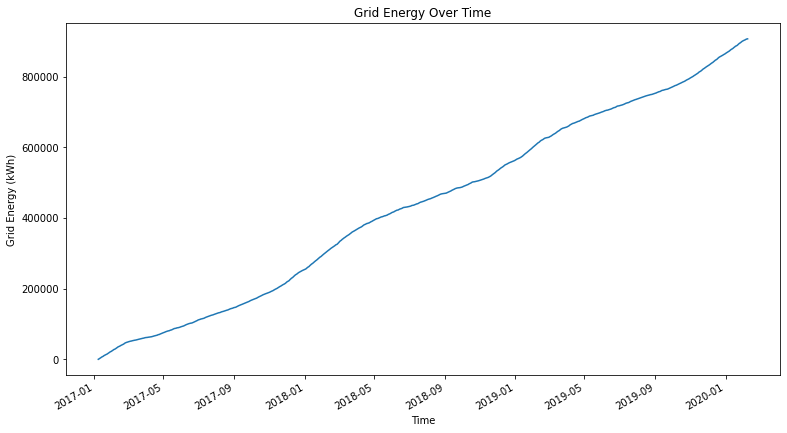

In [26]:
simulation["grid_energy"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Grid Energy (kWh)")
plt.title("Grid Energy Over Time")
plt.show()

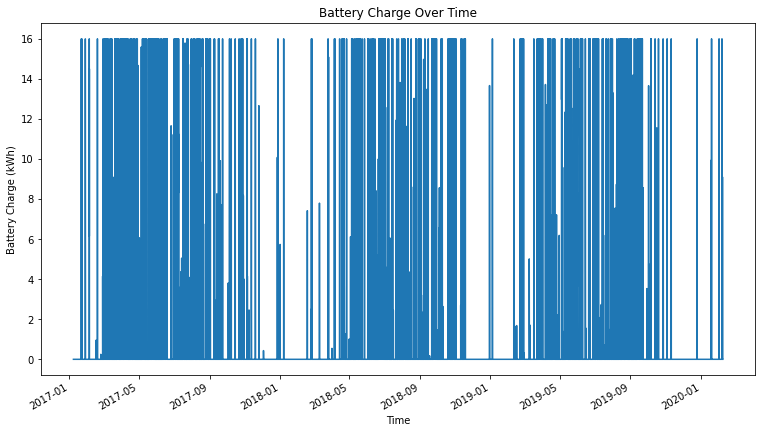

In [27]:
simulation["battery_charge"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Battery Charge (kWh)")
plt.title("Battery Charge Over Time")
plt.show()


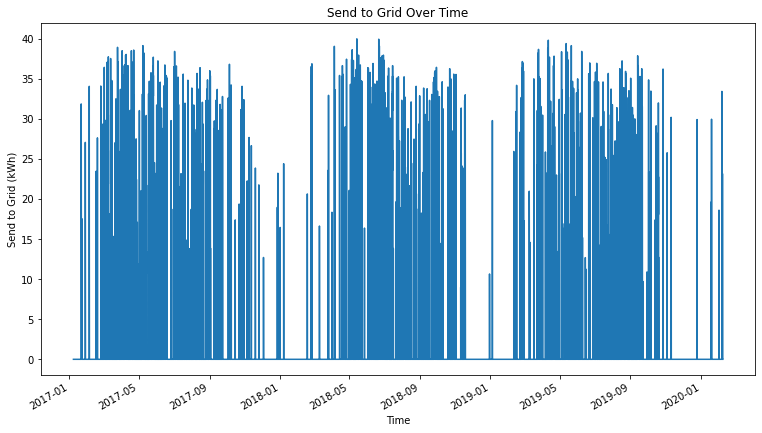

In [28]:
simulation["send_to_grid"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Send to Grid (kWh)")
plt.title("Send to Grid Over Time")
plt.show()

In [29]:
simulation.describe()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price
count,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000
mean,20.286665,20.275136,0.098689,4.178086,1.239433,0.012186,16.781213,2.240920,0.893433,0.150894,3.360456,0.144996,0.002883,52.112591
std,10.314046,10.051677,0.221125,9.361553,4.051851,0.058516,11.062763,7.716435,0.688065,1.002310,7.499119,1.029933,0.006459,12.355105
min,2.506500,2.832800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,12.824750,12.937429,0.000000,0.000000,0.000000,0.000000,11.071000,0.000000,0.493497,0.000000,0.000000,0.000000,0.000000,44.720000
50%,17.027500,17.247404,0.000000,0.000000,0.000000,0.000000,14.859320,0.000000,0.750768,0.000000,0.000000,0.000000,0.000000,51.750000
75%,25.404750,25.288505,0.017000,0.719712,0.000000,0.000000,21.745574,0.000000,1.153680,0.000000,0.719712,0.000000,0.000497,60.070000
max,76.893000,74.854820,0.945000,40.007520,16.000000,0.666667,76.893000,40.007520,5.800835,16.000000,38.398752,15.360000,0.027605,101.990000


In [30]:
simulation.sum()

energy                      1.096596e+06
energy_pred                 1.095972e+06
Dni                         5.334619e+03
production                  2.258464e+05
battery_charge              6.699758e+04
losses                      6.586957e+02
grid_energy                 9.071085e+05
send_to_grid                1.211330e+05
grid_price                  4.828914e+04
saved_to_battery            8.156592e+03
consumed_from_production    1.816495e+05
consumed_from_battery       7.837754e+03
co2_avoided                 1.558340e+02
price                       2.816633e+06
dtype: float64

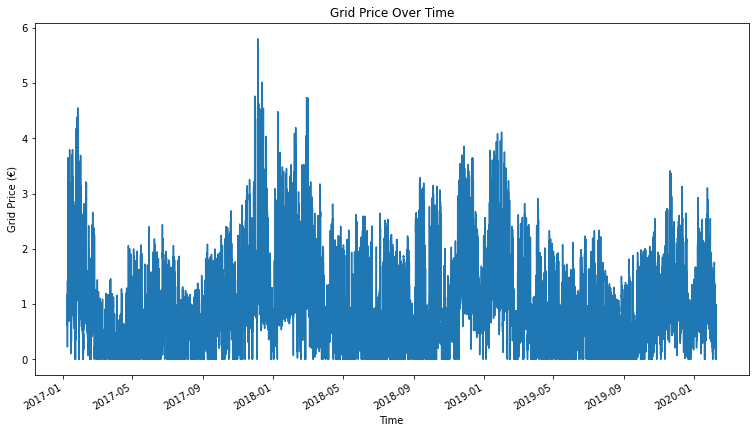

In [31]:
simulation["grid_price"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Grid Price (€)")
plt.title("Grid Price Over Time")
plt.show()

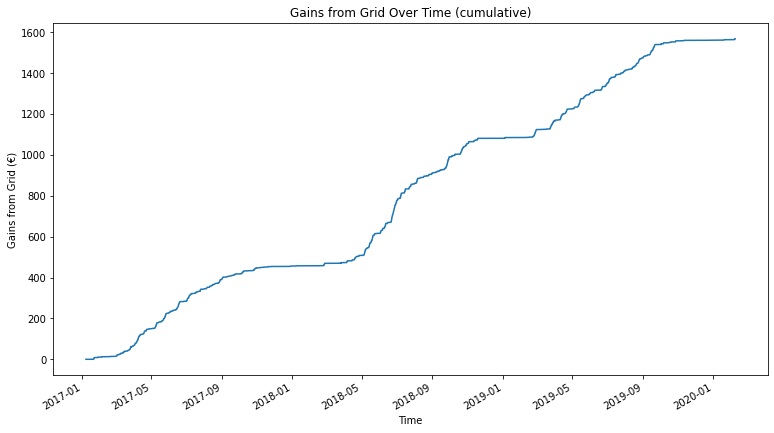

In [32]:
simulation["gains_from_grid"] = simulation["send_to_grid"] * simulation["price"] / 1000 / 4 # send to grid at a quarter of the market value
simulation["gains_from_grid"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Gains from Grid (€)")
plt.title("Gains from Grid Over Time (cumulative)")
plt.show()


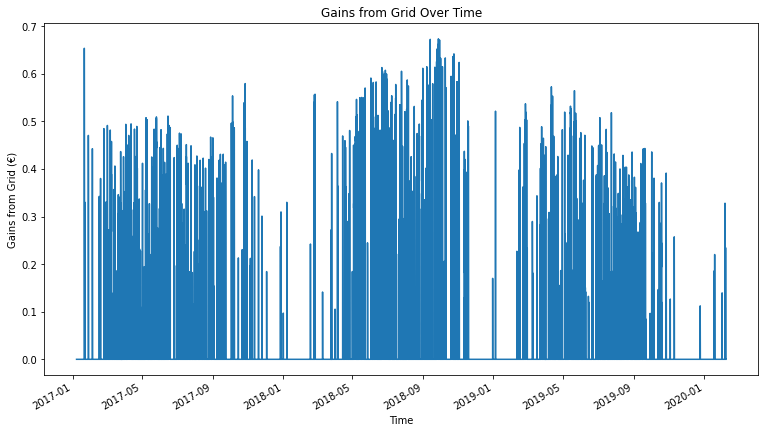

In [33]:
simulation["gains_from_grid"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Gains from Grid (€)")
plt.title("Gains from Grid Over Time")
plt.show()


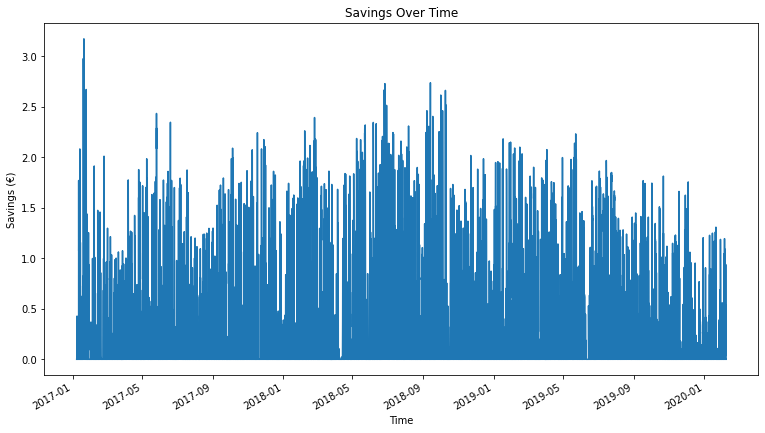

In [34]:
simulation["savings"] = simulation["energy"] * simulation["price"] / 1000 - simulation["grid_price"]
simulation["savings"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings (€)")
plt.title("Savings Over Time")
plt.show()


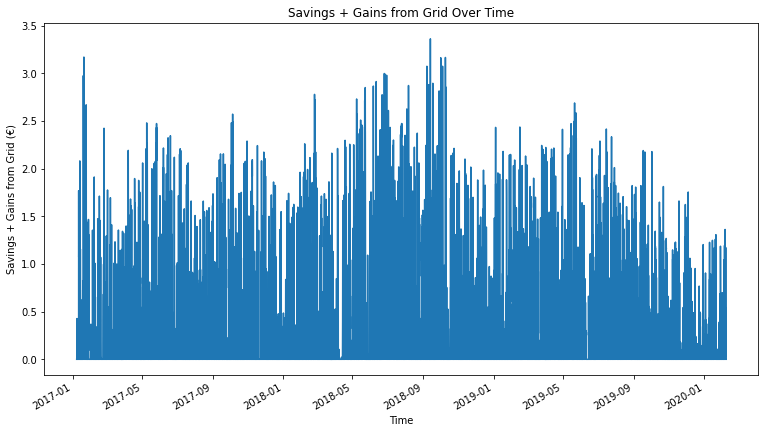

In [35]:
(simulation["savings"] + simulation["gains_from_grid"]).plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings + Gains from Grid (€)")
plt.title("Savings + Gains from Grid Over Time")
plt.show()


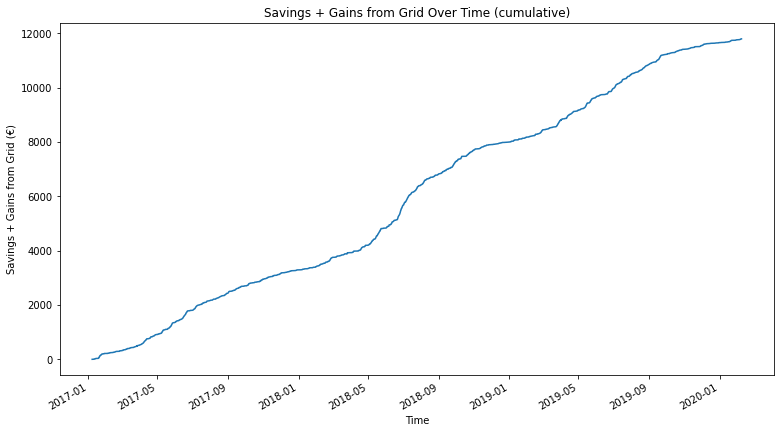

In [36]:
(simulation["savings"] + simulation["gains_from_grid"]).cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings + Gains from Grid (€)")
plt.title("Savings + Gains from Grid Over Time (cumulative)")
plt.show()


In [37]:
simulation.describe()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings
count,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54049.000000,54049.000000
mean,20.286665,20.275136,0.098689,4.178086,1.239433,0.012186,16.781213,2.240920,0.893433,0.150894,3.360456,0.144996,0.002883,52.112591,0.029010,0.189165
std,10.314046,10.051677,0.221125,9.361553,4.051851,0.058516,11.062763,7.716435,0.688065,1.002310,7.499119,1.029933,0.006459,12.355105,0.102683,0.430047
min,2.506500,2.832800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
25%,12.824750,12.937429,0.000000,0.000000,0.000000,0.000000,11.071000,0.000000,0.493497,0.000000,0.000000,0.000000,0.000000,44.720000,0.000000,0.000000
50%,17.027500,17.247404,0.000000,0.000000,0.000000,0.000000,14.859320,0.000000,0.750768,0.000000,0.000000,0.000000,0.000000,51.750000,0.000000,0.000000
75%,25.404750,25.288505,0.017000,0.719712,0.000000,0.000000,21.745574,0.000000,1.153680,0.000000,0.719712,0.000000,0.000497,60.070000,0.000000,0.046553
max,76.893000,74.854820,0.945000,40.007520,16.000000,0.666667,76.893000,40.007520,5.800835,16.000000,38.398752,15.360000,0.027605,101.990000,0.673740,3.172275


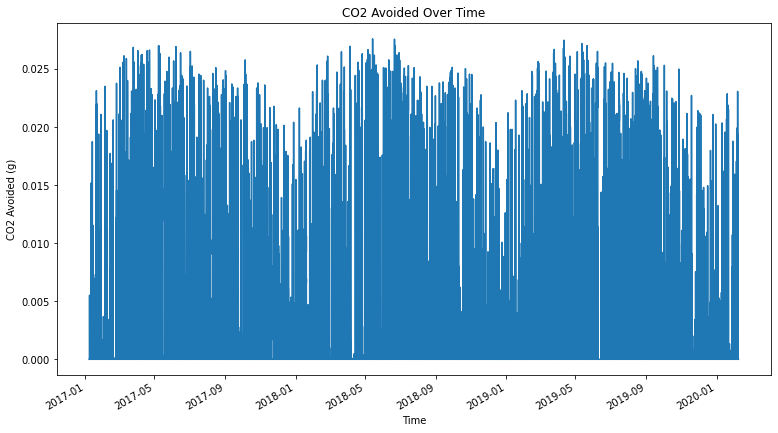

In [38]:
simulation["co2_avoided"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("CO2 Avoided (g)")
plt.title("CO2 Avoided Over Time")
plt.show()

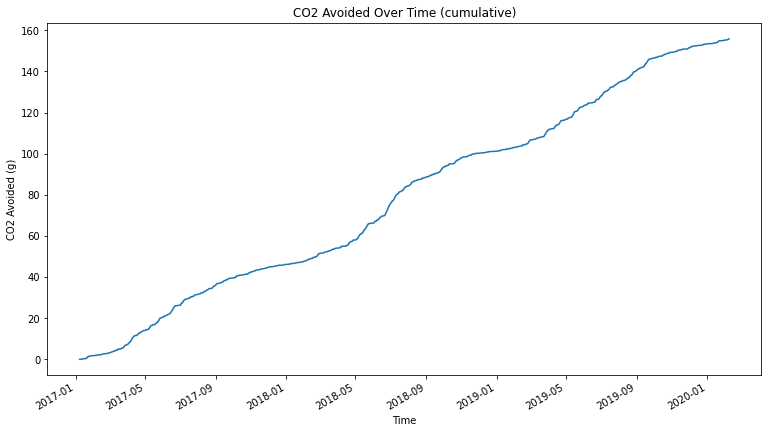

In [39]:
simulation["co2_avoided"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("CO2 Avoided (g)")
plt.title("CO2 Avoided Over Time (cumulative)")
plt.show()

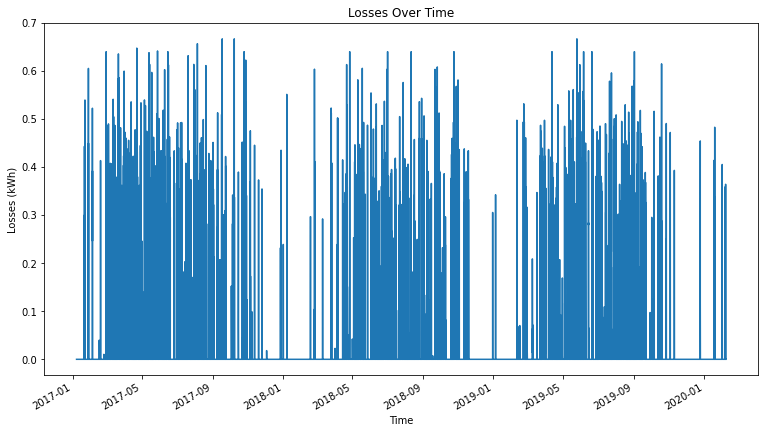

In [40]:
simulation["losses"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Losses (kWh)")
plt.title("Losses Over Time")
plt.show()


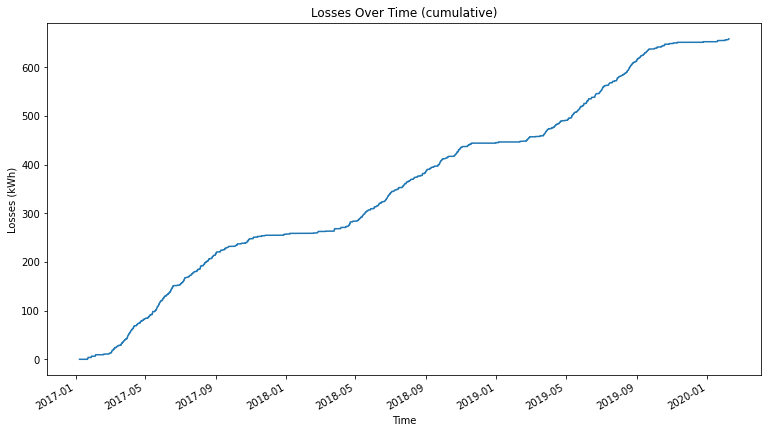

In [41]:
simulation["losses"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Losses (kWh)")
plt.title("Losses Over Time (cumulative)")
plt.show()


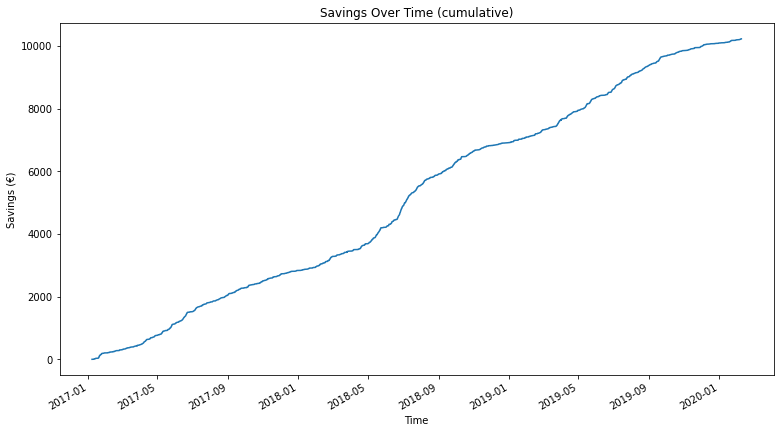

In [42]:
simulation["savings"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Savings (€)")
plt.title("Savings Over Time (cumulative)")
plt.show()


`TODO`: *pie charts* - **autoconsumo** e **autossuficiencia**

- **`autoconsumo`** = `consumed_from_production` - `saved_to_battery`
- **`excess_production`** = `send_to_grid`
- **`losses`** = (done)

-----

- **`autossuficiencia`** = `consumed_from_production` + `consumed_from_battery`
- **`gap_production`** = `grid_energy`
- **`losses`** = (done)

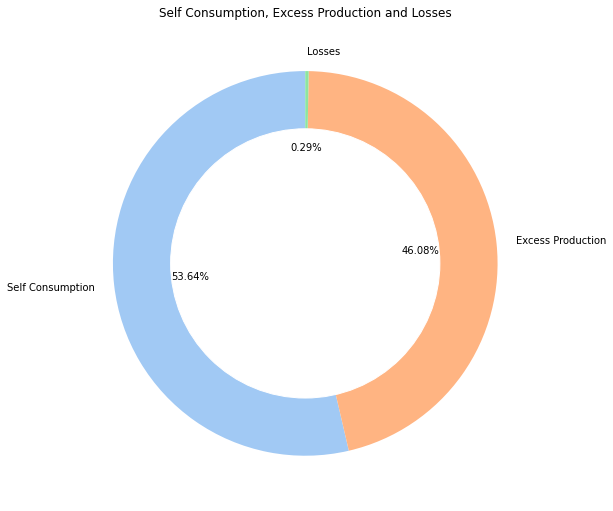

In [43]:
simulation["self_consumption"] = (simulation["consumed_from_production"] + simulation["saved_to_battery"]) / simulation["energy"]  # prod_consumed + stored

autoconsumo = simulation["self_consumption"].sum()
excess_production = (simulation["send_to_grid"] / simulation["energy"]).sum()
losses = (simulation["losses"] / simulation["energy"]).sum()

plt.figure(figsize=(12.8, 7.2))
colors = sns.color_palette("pastel")
plt.pie([autoconsumo, excess_production, losses], colors=colors, labels=["Self Consumption", "Excess Production", "Losses"], autopct="%1.2f%%",
        startangle=90)
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0, 0), 0.7, color="white"))
plt.title("Self Consumption, Excess Production and Losses")
plt.tight_layout()
plt.show()


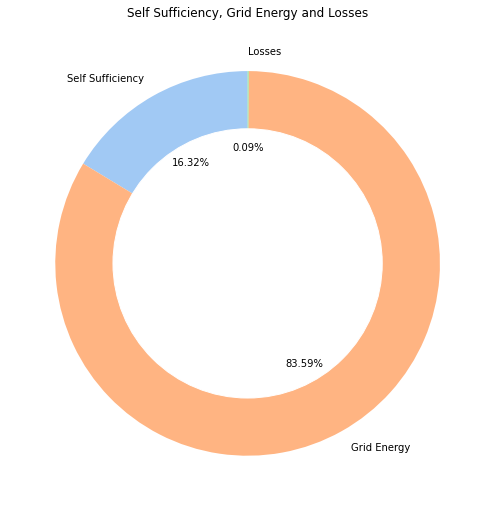

In [44]:
simulation["self_sufficiency"] = (simulation["consumed_from_production"] + simulation["consumed_from_battery"]) / simulation["energy"]

autossuficiencia = simulation["self_sufficiency"].sum()
gap_production = (simulation["grid_energy"] / simulation["energy"]).sum()
losses = (simulation["losses"] / simulation["energy"]).sum()

plt.figure(figsize=(12.8, 7.2))
colors = sns.color_palette("pastel")
plt.pie([autossuficiencia, gap_production, losses], colors=colors, labels=["Self Sufficiency", "Grid Energy", "Losses"], autopct="%1.2f%%",
        startangle=90)
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color="white"))
plt.title("Self Sufficiency, Grid Energy and Losses")
plt.tight_layout()
plt.show()


In [45]:
simulation[simulation["production"] >= simulation["energy"]]

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
time,,,,,,,,,,,,,,,,,,
2017-01-21 09:30:00+00:00,15.4670,15.975115,0.512,21.676032,5.960671,0.248361,0.0,15.467000,0.0,5.960671,15.4670,0.0,0.014956,75.60,0.292326,1.169305,1.385380,1.0
2017-01-21 10:00:00+00:00,18.3740,17.587482,0.611,25.867296,13.154235,0.299732,0.0,18.374000,0.0,7.193564,18.3740,0.0,0.017848,84.00,0.385854,1.543416,1.391508,1.0
2017-01-21 10:30:00+00:00,19.5910,18.994629,0.676,28.619136,16.000000,0.118574,0.0,25.654797,0.0,2.845765,19.5910,0.0,0.019747,84.00,0.538751,1.645644,1.145259,1.0
2017-01-21 11:00:00+00:00,19.4455,19.354773,0.718,30.397248,16.000000,0.000000,0.0,30.397248,0.0,0.000000,19.4455,0.0,0.020974,83.04,0.631047,1.614754,1.000000,1.0
2017-01-21 11:30:00+00:00,19.5540,19.180145,0.744,31.497984,16.000000,0.000000,0.0,31.497984,0.0,0.000000,19.5540,0.0,0.021734,83.04,0.653898,1.623764,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-06 15:30:00+00:00,12.4815,13.125831,0.631,26.714016,16.000000,0.000000,0.0,26.714016,0.0,0.000000,12.4815,0.0,0.018433,37.94,0.253382,0.473548,1.000000,1.0
2020-02-06 16:00:00+00:00,13.0060,11.984644,0.537,22.734432,16.000000,0.000000,0.0,22.734432,0.0,0.000000,13.0060,0.0,0.015687,38.06,0.216318,0.495008,1.000000,1.0
2020-02-06 16:30:00+00:00,10.5640,12.368328,0.382,16.172352,16.000000,0.000000,0.0,16.172352,0.0,0.000000,10.5640,0.0,0.011159,38.06,0.153880,0.402066,1.000000,1.0


In [46]:
simulation.describe()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
count,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54055.000000,54055.000000,54055.000000,54055.000000,54049.000000,54049.000000,54049.000000,54055.000000,54055.000000
mean,20.286665,20.275136,0.098689,4.178086,1.239433,0.012186,16.781213,2.240920,0.893433,0.150894,3.360456,0.144996,0.002883,52.112591,0.029010,0.189165,0.162644,0.163352
std,10.314046,10.051677,0.221125,9.361553,4.051851,0.058516,11.062763,7.716435,0.688065,1.002310,7.499119,1.029933,0.006459,12.355105,0.102683,0.430047,0.356082,0.335353
min,2.506500,2.832800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000
25%,12.824750,12.937429,0.000000,0.000000,0.000000,0.000000,11.071000,0.000000,0.493497,0.000000,0.000000,0.000000,0.000000,44.720000,0.000000,0.000000,0.000000,0.000000
50%,17.027500,17.247404,0.000000,0.000000,0.000000,0.000000,14.859320,0.000000,0.750768,0.000000,0.000000,0.000000,0.000000,51.750000,0.000000,0.000000,0.000000,0.000000
75%,25.404750,25.288505,0.017000,0.719712,0.000000,0.000000,21.745574,0.000000,1.153680,0.000000,0.719712,0.000000,0.000497,60.070000,0.000000,0.046553,0.034695,0.044816
max,76.893000,74.854820,0.945000,40.007520,16.000000,0.666667,76.893000,40.007520,5.800835,16.000000,38.398752,15.360000,0.027605,101.990000,0.673740,3.172275,3.850911,1.000000


In [47]:
simulation.sum()

energy                      1.096596e+06
energy_pred                 1.095972e+06
Dni                         5.334619e+03
production                  2.258464e+05
battery_charge              6.699758e+04
losses                      6.586957e+02
grid_energy                 9.071085e+05
send_to_grid                1.211330e+05
grid_price                  4.828914e+04
saved_to_battery            8.156592e+03
consumed_from_production    1.816495e+05
consumed_from_battery       7.837754e+03
co2_avoided                 1.558340e+02
price                       2.816633e+06
gains_from_grid             1.567967e+03
savings                     1.022417e+04
self_consumption            8.791717e+03
self_sufficiency            8.830013e+03
dtype: float64

### Scenario 2

At midnight, predict the production and the consumption of the next day. Then, fetch energy from the grid and store it in the battery.

In [48]:
energy_df = pd.read_csv("../data/BANES_v4_featureimportance.csv", parse_dates=["time"])
energy_df.head()


,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
0,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,0.000,0.000,0.005,0.000,0.000,0.000
1,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,0.000,0.005,0.005,0.005,0.000,0.000
2,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,0.000,0.005,0.006,0.005,0.005,0.000
3,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,0.000,0.006,0.005,0.006,0.005,0.005
4,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,0.006,0.005,0.005,0.005,0.006,0.005


In [49]:
# pick 10 locations at random
locs = energy_df.sample(10, random_state=1).index.tolist()
locations = energy_df.iloc[locs]["location"]
assert len(locations) == 10 and len(np.unique(locations)) == 10
energy_df = energy_df[energy_df["location"].isin(locations)]
energy_df.head()


,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338


In [50]:
# select rows at midnight
X = energy_df.loc[(energy_df["time"].dt.hour == 0) & (energy_df["time"].dt.minute == 0)]
X = X.drop(["time", "location", "energy"], axis=1)
X


,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
45650,0.3390,0.3320,0.3420,0.3340,0.3350,0.3340
45698,0.3450,0.3420,0.3450,0.3350,0.3360,0.3330
45746,0.3380,0.3350,0.3420,0.3370,0.3390,0.3400
45794,0.3400,0.3340,0.3400,0.3370,0.3390,0.3440
45842,0.3430,0.3350,0.3390,0.3310,0.3420,0.3420
...,...,...,...,...,...,...
2412189,0.9055,0.7720,4.9820,0.9365,0.8920,0.8650
2412237,0.8285,0.8895,4.9135,1.0035,0.9120,0.9075
2412285,0.8700,0.8895,4.5500,0.8605,0.8425,0.8160
2412333,0.8365,0.8785,4.5230,0.7910,0.7905,0.8030


In [51]:
energy_df.loc[(energy_df["time"].dt.hour == 0) & (energy_df["time"].dt.minute == 0), "energy_pred"] = model.predict(X)
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334,0.34056
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335,NaN
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334,NaN
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333,NaN
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338,NaN


In [52]:
energy_df.loc[(energy_df["time"].dt.hour == 0) & (energy_df["time"].dt.minute == 0)]

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.3420,0.3390,0.3320,0.3420,0.3340,0.3350,0.3340,0.340560
45698,##Northgate House Electricity Supply 2,2017-01-09 00:00:00+00:00,0.3370,0.3450,0.3420,0.3450,0.3350,0.3360,0.3330,0.343379
45746,##Northgate House Electricity Supply 2,2017-01-10 00:00:00+00:00,0.3370,0.3380,0.3350,0.3420,0.3370,0.3390,0.3400,0.340560
45794,##Northgate House Electricity Supply 2,2017-01-11 00:00:00+00:00,0.3420,0.3400,0.3340,0.3400,0.3370,0.3390,0.3440,0.340560
45842,##Northgate House Electricity Supply 2,2017-01-12 00:00:00+00:00,0.3370,0.3430,0.3350,0.3390,0.3310,0.3420,0.3420,0.342466
...,...,...,...,...,...,...,...,...,...,...
2412189,Twerton Infant School Electricity Supply,2020-02-04 00:00:00+00:00,0.9795,0.9055,0.7720,4.9820,0.9365,0.8920,0.8650,0.900921
2412237,Twerton Infant School Electricity Supply,2020-02-05 00:00:00+00:00,0.8235,0.8285,0.8895,4.9135,1.0035,0.9120,0.9075,0.870827
2412285,Twerton Infant School Electricity Supply,2020-02-06 00:00:00+00:00,0.8925,0.8700,0.8895,4.5500,0.8605,0.8425,0.8160,0.876109
2412333,Twerton Infant School Electricity Supply,2020-02-07 00:00:00+00:00,0.8655,0.8365,0.8785,4.5230,0.7910,0.7905,0.8030,0.844085


In [53]:
# shift energy 1
energy_df["energy_shift_1"] = energy_df["energy_pred"].shift(1)

In [54]:
# predict the full day
for i in range(1, 48):
    X = energy_df.loc[(energy_df["time"].dt.hour == i // 2) & (energy_df["time"].dt.minute == i % 2 * 30)]
    X = X.drop(["time", "location", "energy", "energy_lag_1"], axis=1)
    X = X[["energy_shift_1", "energy_lag_46", "energy_lag_328", "energy_lag_328", "energy_lag_335",	"energy_lag_336"]]
    energy_df.loc[(energy_df["time"].dt.hour == i // 2) & (energy_df["time"].dt.minute == i % 2 * 30), "energy_pred"] = model.predict(X)
    energy_df["energy_shift_1"] = energy_df["energy_pred"].shift(1)


In [55]:
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred,energy_shift_1
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334,0.340560,NaN
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335,0.340560,0.340560
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334,0.340560,0.340560
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333,0.340137,0.340560
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338,0.341049,0.340137


In [56]:
energy_df

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred,energy_shift_1
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.3420,0.3390,0.3320,0.3420,0.3340,0.3350,0.3340,0.340560,NaN
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.3430,0.3420,0.3350,0.3370,0.3330,0.3340,0.3350,0.340560,0.340560
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.3420,0.3430,0.3380,0.3360,0.3380,0.3330,0.3340,0.340560,0.340560
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.3350,0.3420,0.3410,0.3350,0.3410,0.3380,0.3330,0.340137,0.340560
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.3380,0.3350,0.3420,0.3350,0.3450,0.3410,0.3380,0.341049,0.340137
...,...,...,...,...,...,...,...,...,...,...,...
2412377,Twerton Infant School Electricity Supply,2020-02-07 22:00:00+00:00,0.7370,0.7560,0.8375,0.7220,0.6745,0.6665,0.7455,1.544401,1.887341
2412378,Twerton Infant School Electricity Supply,2020-02-07 22:30:00+00:00,0.6665,0.7370,0.8365,0.7530,0.7035,0.6745,0.6665,1.256524,1.544401
2412379,Twerton Infant School Electricity Supply,2020-02-07 23:00:00+00:00,0.6695,0.6665,0.8655,0.7170,0.7915,0.7035,0.6745,1.063839,1.256524
2412380,Twerton Infant School Electricity Supply,2020-02-07 23:30:00+00:00,0.6870,0.6695,0.8865,4.4340,0.7380,0.7915,0.7035,0.949056,1.063839


In [57]:
energy_df = energy_df.drop(["energy_shift_1"], axis=1)
energy_df = energy_df.groupby(["time"]).sum()
energy_df.head()


,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
time,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.4145,15.6905,19.0515,13.7410,13.665,10.4265,12.630360
2017-01-08 00:30:00+00:00,15.5335,12.1005,15.7690,16.3645,14.3410,13.741,13.6650,13.245420
2017-01-08 01:00:00+00:00,15.8120,15.5335,15.9685,15.1790,13.9740,14.341,13.7410,13.914445
2017-01-08 01:30:00+00:00,15.2760,15.8120,15.6965,14.6085,13.7320,13.974,14.3410,14.195084
2017-01-08 02:00:00+00:00,15.6635,15.2760,15.5890,14.2770,13.7605,13.732,13.9740,14.451682


In [58]:
# sum the energy in a day
consumption_pred = energy_df.groupby(energy_df.index.date).sum()
consumption_pred

,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
2017-01-08,704.6990,704.8260,776.9045,636.7765,626.2460,623.0270,621.4795,661.065857
2017-01-09,1212.0825,1213.1880,704.6655,737.2205,736.7910,737.9110,737.8375,714.182495
2017-01-10,1271.3735,1270.3910,1210.5335,1141.2470,1140.7555,1141.0375,1140.6610,1136.475952
2017-01-11,1152.8515,1152.8605,1271.6145,1215.4875,1212.2645,1211.7735,1210.8200,1221.234497
2017-01-12,1249.3505,1247.8710,1153.0790,1287.2605,1285.9060,1285.1790,1285.8375,1237.715210
...,...,...,...,...,...,...,...,...
2020-02-04,1071.3010,1069.7140,988.6685,1061.7005,1059.2860,1059.1150,1058.7945,1026.743652
2020-02-05,1039.3685,1038.9590,1073.9010,975.8970,966.5530,964.5195,963.3890,988.482422
2020-02-06,576.8400,576.8265,533.0080,499.1065,503.1465,503.4345,504.6915,518.464294
2020-02-07,537.5340,537.4065,563.4330,430.8975,436.7040,437.6365,437.7070,472.607330


In [59]:
mae = mean_absolute_error(energy_df["energy"], energy_df["energy_pred"])
mse = mean_squared_error(energy_df["energy"], energy_df["energy_pred"])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(energy_df["energy"], energy_df["energy_pred"])
r2 = r2_score(energy_df["energy"], energy_df["energy_pred"])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 2.5932348431400523
MSE: 16.567247111749065
RMSE: 4.070288332753475
MAPE: 0.13106198400780658
R2: 0.8442651067243647


In [60]:
print("Performance metrics on all-day sum:")
sum_df = energy_df.groupby(energy_df.index.date).sum()

mae = mean_absolute_error(sum_df["energy"], sum_df["energy_pred"])
mse = mean_squared_error(sum_df["energy"], sum_df["energy_pred"])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(sum_df["energy"], sum_df["energy_pred"])
r2 = r2_score(sum_df["energy"], sum_df["energy_pred"])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

Performance metrics on all-day sum:
MAE: 88.61460432500087
MSE: 15773.744188504394
RMSE: 125.59356746467708
MAPE: 0.09409555393327584
R2: 0.8470226857958223


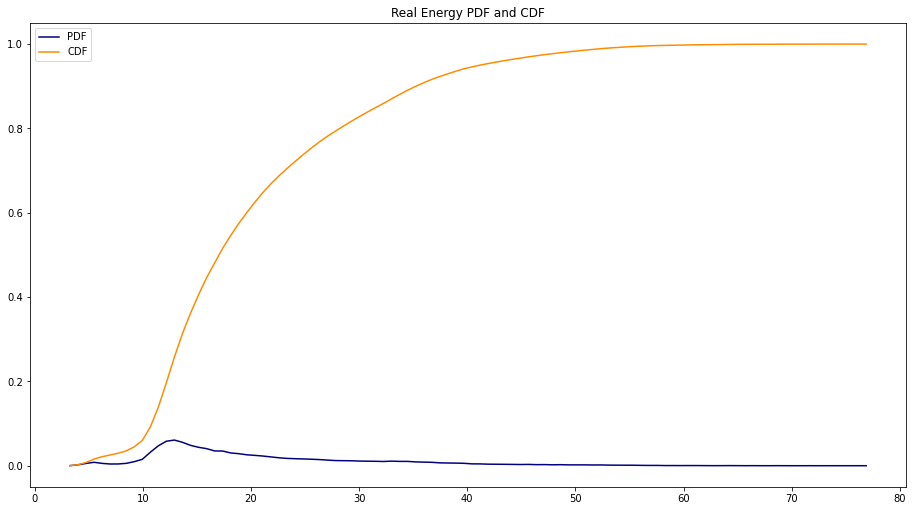

In [61]:
# plot PDF of energy
data = energy_df["energy"]

count, bins = np.histogram(data, bins=100)

pdf = count / sum(count)

cdf = np.cumsum(pdf)

plt.figure(figsize=(12.8, 7.2))
plt.plot(bins[1:], pdf, label="PDF", c="navy")
plt.plot(bins[1:], cdf, label="CDF", c="darkorange")
plt.title("Real Energy PDF and CDF")
plt.tight_layout()
plt.legend()
plt.show()


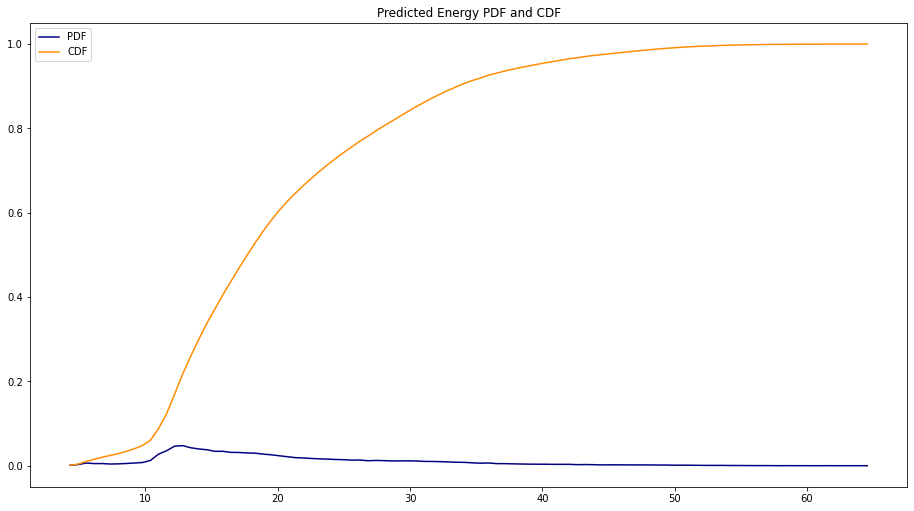

In [62]:
# plot PDF of energy
data = energy_df["energy_pred"]

count, bins = np.histogram(data, bins=100)

pdf = count / sum(count)

cdf = np.cumsum(pdf)

plt.figure(figsize=(12.8, 7.2))
plt.plot(bins[1:], pdf, label="PDF", c="navy")
plt.plot(bins[1:], cdf, label="CDF", c="darkorange")
plt.title("Predicted Energy PDF and CDF")
plt.tight_layout()
plt.legend()
plt.show()

In [63]:
energy_df.describe()

,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
count,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.287529,20.278518,20.220292,20.219460,20.219331,20.219138,20.266901
std,10.314216,10.314299,10.321048,10.288382,10.288791,10.288825,10.288919,9.402152
min,2.506500,2.506500,2.506500,2.433500,2.433500,2.433500,2.433500,3.688808
25%,12.825000,12.825000,12.825000,12.768000,12.764000,12.764000,12.763500,13.273851
50%,17.028000,17.032000,17.033500,17.025500,17.025500,17.026000,17.027000,17.703272
75%,25.407000,25.407000,25.404000,25.297000,25.296500,25.296500,25.296500,25.311207
max,76.893000,76.893000,76.893000,76.893000,76.893000,76.893000,76.893000,64.557213


In [64]:
simulation.head()

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
time,,,,,,,,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.630360,0.0,0.0,0.0,0.0,12.1005,0.0,0.799722,0.0,0.0,0.0,0.0,66.09,0.0,0.0,0.0,0.0
2017-01-08 00:30:00+00:00,15.5335,13.138655,0.0,0.0,0.0,0.0,15.5335,0.0,1.026609,0.0,0.0,0.0,0.0,66.09,0.0,0.0,0.0,0.0
2017-01-08 01:00:00+00:00,15.8120,15.286879,0.0,0.0,0.0,0.0,15.8120,0.0,1.094190,0.0,0.0,0.0,0.0,69.20,0.0,0.0,0.0,0.0
2017-01-08 01:30:00+00:00,15.2760,15.399491,0.0,0.0,0.0,0.0,15.2760,0.0,1.057099,0.0,0.0,0.0,0.0,69.20,0.0,0.0,0.0,0.0
2017-01-08 02:00:00+00:00,15.6635,15.031993,0.0,0.0,0.0,0.0,15.6635,0.0,0.956570,0.0,0.0,0.0,0.0,61.07,0.0,0.0,0.0,0.0


In [65]:
production_pred = simulation.groupby(simulation.index.date).sum()
production_pred

,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
2017-01-08,704.6990,691.148740,0.311,13.166496,0.000000,0.000000,691.532504,0.000000,41.445185,0.000000,13.166496,0.000000,0.009085,2880.56,0.000000,0.726466,1.084357,1.084357
2017-01-09,1212.0825,1098.562966,0.126,5.334336,0.000000,0.000000,1206.748164,0.000000,87.108271,0.000000,5.334336,0.000000,0.003681,3353.28,0.000000,0.412903,0.155943,0.155943
2017-01-10,1271.3735,1235.372408,0.000,0.000000,0.000000,0.000000,1271.373500,0.000000,86.045948,0.000000,0.000000,0.000000,0.000000,3163.68,0.000000,0.000000,0.000000,0.000000
2017-01-11,1152.8515,1173.128563,3.595,152.197920,0.000000,0.000000,1000.653580,0.000000,73.213752,0.000000,152.197920,0.000000,0.105017,3462.98,0.000000,12.153473,4.260224,4.260224
2017-01-12,1249.3505,1246.680686,0.000,0.000000,0.000000,0.000000,1249.350500,0.000000,97.649045,0.000000,0.000000,0.000000,0.000000,3639.62,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-04,1071.3010,1063.240765,2.485,105.204960,0.000000,0.000000,966.096040,0.000000,36.885909,0.000000,105.204960,0.000000,0.072591,1833.66,0.000000,4.416052,2.906034,2.906034
2020-02-05,1039.3685,1036.096490,3.868,163.755648,0.000000,0.000000,875.612852,0.000000,32.327125,0.000000,163.755648,0.000000,0.112991,1750.46,0.000000,6.540935,4.983304,4.983304
2020-02-06,576.8400,565.468101,9.751,412.818336,179.918551,1.282552,263.255349,350.598133,9.697954,16.000000,298.200536,15.384115,0.284845,1852.26,3.483210,12.774248,16.193800,17.198130
2020-02-07,537.5340,522.468652,2.527,106.983072,13.804316,0.743407,431.294335,39.119500,17.558139,9.102939,97.500844,8.738821,0.073818,1918.64,0.389626,4.370088,5.187859,5.301311


In [66]:
cons_m1 = energy_df[(energy_df.index.hour >= 9) & (energy_df.index.hour <= 18)]
cons_m1 = cons_m1.groupby(cons_m1.index.date).sum()
cons_m1 = cons_m1[["energy_pred"]]

# parse index to string
cons_m1.index = pd.to_datetime(cons_m1.index).strftime("%Y-%m-%d")

cons_m1 = cons_m1.to_dict()["energy_pred"]


In [67]:
cons_m2 = energy_df[(energy_df.index.hour >= 6) & (energy_df.index.hour <= 9)]
cons_m2 = cons_m2.groupby(cons_m2.index.date).sum()
cons_m2 = cons_m2[["energy_pred"]]

# parse index to string
cons_m2.index = pd.to_datetime(cons_m2.index).strftime("%Y-%m-%d")

cons_m2 = cons_m2.to_dict()["energy_pred"]


In [68]:
simulation.reset_index(inplace=True)
simulation.head()

,time,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
0,2017-01-08 00:00:00+00:00,12.1005,12.630360,0.0,0.0,0.0,0.0,12.1005,0.0,0.799722,0.0,0.0,0.0,0.0,66.09,0.0,0.0,0.0,0.0
1,2017-01-08 00:30:00+00:00,15.5335,13.138655,0.0,0.0,0.0,0.0,15.5335,0.0,1.026609,0.0,0.0,0.0,0.0,66.09,0.0,0.0,0.0,0.0
2,2017-01-08 01:00:00+00:00,15.8120,15.286879,0.0,0.0,0.0,0.0,15.8120,0.0,1.094190,0.0,0.0,0.0,0.0,69.20,0.0,0.0,0.0,0.0
3,2017-01-08 01:30:00+00:00,15.2760,15.399491,0.0,0.0,0.0,0.0,15.2760,0.0,1.057099,0.0,0.0,0.0,0.0,69.20,0.0,0.0,0.0,0.0
4,2017-01-08 02:00:00+00:00,15.6635,15.031993,0.0,0.0,0.0,0.0,15.6635,0.0,0.956570,0.0,0.0,0.0,0.0,61.07,0.0,0.0,0.0,0.0


In [69]:
# remove last row
simulation = simulation.iloc[:-1]
simulation.tail()

,time,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
54049,2020-02-07 21:30:00+00:00,4.1560,6.955046,0.0,0.0,0.0,0.0,4.1560,0.0,0.182906,0.0,0.0,0.0,0.0,44.01,0.0,0.0,0.0,0.0
54050,2020-02-07 22:00:00+00:00,4.1160,3.990874,0.0,0.0,0.0,0.0,4.1160,0.0,0.178099,0.0,0.0,0.0,0.0,43.27,0.0,0.0,0.0,0.0
54051,2020-02-07 22:30:00+00:00,4.1025,3.905673,0.0,0.0,0.0,0.0,4.1025,0.0,0.177515,0.0,0.0,0.0,0.0,43.27,0.0,0.0,0.0,0.0
54052,2020-02-07 23:00:00+00:00,4.0775,3.883157,0.0,0.0,0.0,0.0,4.0775,0.0,0.170236,0.0,0.0,0.0,0.0,41.75,0.0,0.0,0.0,0.0
54053,2020-02-07 23:30:00+00:00,4.1640,3.948422,0.0,0.0,0.0,0.0,4.1640,0.0,0.173847,0.0,0.0,0.0,0.0,41.75,0.0,0.0,0.0,0.0


In [70]:
def literature_algorithm(x):
    global current_capacity

    day = pd.to_datetime(x.time).strftime("%Y-%m-%d")
    
    if x.time.hour == 0 and x.time.minute == 0:
        # it is midnight
        consumption_prediction = consumption_pred[consumption_pred.index.astype(str) == day]["energy_pred"].values[0]
        production_prediction = production_pred[production_pred.index.astype(str) == day]["production"].values[0]

        m1 = cons_m1[day] / consumption_prediction
        m2 = cons_m2[day] / consumption_prediction

        # battery available
        battery_available = BATTERY_CAP - current_capacity

        if production_prediction > consumption_prediction * m1:
            # production is greater than consumption
            
            excess = production_prediction - consumption_prediction * m1

            if excess < battery_available:
                # battery is not full
                # charge battery without the excess
                current_capacity += battery_available - excess
                x["grid_energy"] += (battery_available - excess) * (1 + efficiency)
                x["losses"] += (battery_available - excess) * (1 - efficiency)
            else:
                # battery will be full
                # charge battery with the consumption in the morning
                current_capacity += min(consumption_prediction * m2, battery_available)
                x["grid_energy"] += min(consumption_prediction * m2, battery_available) * (1 + efficiency)
                x["losses"] += min(consumption_prediction * m2, battery_available) * (1 - efficiency)
        else:
            # production is smaller than consumption
            # pre-charge battery to its maximum capacity
            current_capacity += battery_available
            x["grid_energy"] += battery_available * (1 + efficiency)
            x["losses"] += battery_available * (1 - efficiency)

    return baseline_algorithm1(x)

In [71]:
simulation["battery_charge"] = 0
simulation["losses"] = 0
simulation["grid_energy"] = 0
simulation["send_to_grid"] = 0
simulation["grid_price"] = 0
simulation["saved_to_battery"] = 0
simulation["consumed_from_production"] = 0
simulation["consumed_from_battery"] = 0

simulation.apply(literature_algorithm, axis=1)

,time,energy,energy_pred,Dni,production,battery_charge,losses,grid_energy,send_to_grid,grid_price,saved_to_battery,consumed_from_production,consumed_from_battery,co2_avoided,price,gains_from_grid,savings,self_consumption,self_sufficiency
0,2017-01-08 00:00:00+00:00,12.1005,12.630360,0.0,0.0,3.41548,0.484020,31.360000,0.0,0,0.0,0.0,12.100500,0.0,66.09,0.0,0.0,0.0,0.0
1,2017-01-08 00:30:00+00:00,15.5335,13.138655,0.0,0.0,0.00000,0.136619,12.254639,0.0,0,0.0,0.0,3.278861,0.0,66.09,0.0,0.0,0.0,0.0
2,2017-01-08 01:00:00+00:00,15.8120,15.286879,0.0,0.0,0.00000,0.000000,15.812000,0.0,0,0.0,0.0,0.000000,0.0,69.20,0.0,0.0,0.0,0.0
3,2017-01-08 01:30:00+00:00,15.2760,15.399491,0.0,0.0,0.00000,0.000000,15.276000,0.0,0,0.0,0.0,0.000000,0.0,69.20,0.0,0.0,0.0,0.0
4,2017-01-08 02:00:00+00:00,15.6635,15.031993,0.0,0.0,0.00000,0.000000,15.663500,0.0,0,0.0,0.0,0.000000,0.0,61.07,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54049,2020-02-07 21:30:00+00:00,4.1560,6.955046,0.0,0.0,0.00000,0.000000,4.156000,0.0,0,0.0,0.0,0.000000,0.0,44.01,0.0,0.0,0.0,0.0
54050,2020-02-07 22:00:00+00:00,4.1160,3.990874,0.0,0.0,0.00000,0.000000,4.116000,0.0,0,0.0,0.0,0.000000,0.0,43.27,0.0,0.0,0.0,0.0
54051,2020-02-07 22:30:00+00:00,4.1025,3.905673,0.0,0.0,0.00000,0.000000,4.102500,0.0,0,0.0,0.0,0.000000,0.0,43.27,0.0,0.0,0.0,0.0
54052,2020-02-07 23:00:00+00:00,4.0775,3.883157,0.0,0.0,0.00000,0.000000,4.077500,0.0,0,0.0,0.0,0.000000,0.0,41.75,0.0,0.0,0.0,0.0


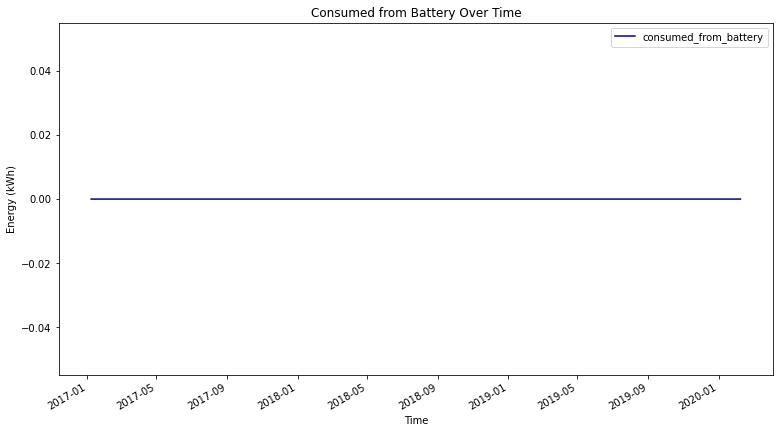

In [72]:
simulation.plot(x="time", y="consumed_from_battery", figsize=(12.8, 7.2), c="darkblue")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.title("Consumed from Battery Over Time")
plt.show()